In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

In [ ]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

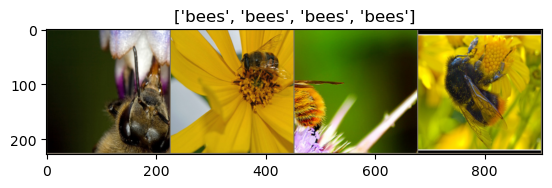

In [9]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

## L1 + L2 Regularization (Elastic Net)

In [10]:
model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

In [ ]:
import copy 

def train_model_elastic_net(model, criterion, optimizer, scheduler, num_epochs=25, lambda_l1=0.01, lambda_l2=0.001):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    l1_penalty = 0.0
                    l2_penalty = 0.0
                    for param in model.parameters():
                        l1_penalty += torch.sum(torch.abs(param))
                        l2_penalty += torch.sum(param ** 2)
                    loss += lambda_l1 * l1_penalty + lambda_l2 * l2_penalty

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history


criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9) 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


lambda_l1 = 0.01
lambda_l2 = 0.001

model_ft, train_loss_hist_en, val_loss_hist_en, train_acc_hist_en, val_acc_hist_en = train_model_elastic_net(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25, lambda_l1=lambda_l1, lambda_l2=lambda_l2)



Epoch 0/24
----------
train Loss: 1455.3276 Acc: 0.6680
val Loss: 1177.3102 Acc: 0.8954

Epoch 1/24
----------
train Loss: 955.0163 Acc: 0.7582
val Loss: 753.9798 Acc: 0.9281

Epoch 2/24
----------
train Loss: 609.8438 Acc: 0.7623
val Loss: 482.6069 Acc: 0.8889

Epoch 3/24
----------
train Loss: 395.6996 Acc: 0.7295
val Loss: 319.9178 Acc: 0.8366

Epoch 4/24
----------
train Loss: 267.9437 Acc: 0.6926
val Loss: 222.5151 Acc: 0.7908

Epoch 5/24
----------
train Loss: 189.0630 Acc: 0.6721
val Loss: 160.6736 Acc: 0.8170

Epoch 6/24
----------
train Loss: 140.2099 Acc: 0.7705
val Loss: 122.5977 Acc: 0.7778

Epoch 7/24
----------
train Loss: 118.5551 Acc: 0.7992
val Loss: 116.2109 Acc: 0.8758

Epoch 8/24
----------
train Loss: 114.8261 Acc: 0.7664
val Loss: 113.2994 Acc: 0.8497

Epoch 9/24
----------
train Loss: 112.0369 Acc: 0.7992
val Loss: 110.6567 Acc: 0.8693

Epoch 10/24
----------
train Loss: 109.5067 Acc: 0.7910
val Loss: 108.5925 Acc: 0.8758

Epoch 11/24
----------
train Loss: 107.0

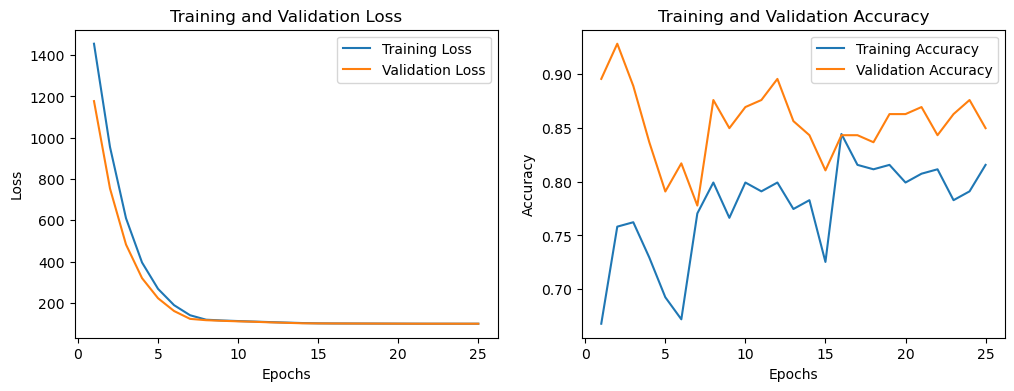

In [ ]:

epochs = range(1, 26)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_hist_en, label='Training Loss')
plt.plot(epochs, val_loss_hist_en, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_hist_en, label='Training Accuracy')
plt.plot(epochs, val_acc_hist_en, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

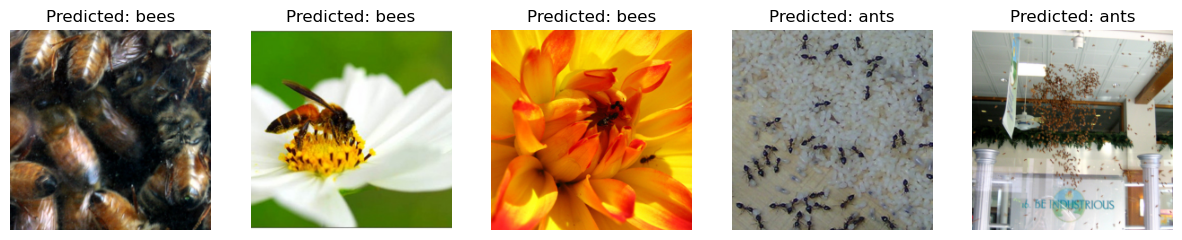

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def visualize_predictions(model, num_images=5):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 5))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Get predictions
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(1, num_images, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    plt.show()
                    return

visualize_predictions(model_ft)

In [14]:
import numpy as np
from sklearn.metrics import classification_report

def generate_classification_report(model, dataloader):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    print("Classification Report:")
    print(classification_report(true_labels, pred_labels, target_names=class_names))

    overall_acc = (np.array(true_labels) == np.array(pred_labels)).mean()
    print(f"Overall Accuracy: {overall_acc:.4f}")

generate_classification_report(model_ft, dataloaders['val'])

Classification Report:
              precision    recall  f1-score   support

        ants       0.92      0.93      0.92        70
        bees       0.94      0.93      0.93        83

    accuracy                           0.93       153
   macro avg       0.93      0.93      0.93       153
weighted avg       0.93      0.93      0.93       153

Overall Accuracy: 0.9281


END 